Pipelines: Mass Total + Source Parametric
=========================================

Using a pipeline composed of two phases this runner fits `Interferometer` data of a strong lens system, where in
the final phase of the pipeline:

 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source galaxy's two `LightProfile`'s are modeled as `EllipticalSersic``..

This uses the pipeline (Check it out full description of the pipeline):

`autolens_workspace/pipelines/interferometer/pipelines/mass_power_law__source_parametric.py`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import numpy as np

dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Using the dataset path, load the data (image, noise-map, PSF) as an `Interferometer` object from .fits files.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


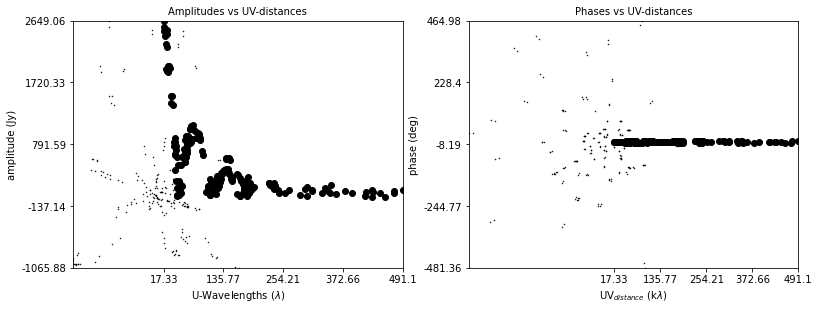

In [2]:
interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()

The perform a fit, we need two masks, firstly a ‘real-space mask’ which defines the grid the image of the lensed 
source galaxy is evaluated using.

In [3]:
real_space_mask = al.Mask2D.circular(
    shape_native=(200, 200), pixel_scales=0.05, radius=3.0
)

We also need a ‘visibilities mask’ which defining which visibilities are omitted from the chi-squared evaluation.

In [4]:
visibilities_mask = np.full(fill_value=False, shape=interferometer.visibilities.shape)

Make a quick subplot to make sure the data looks as we expect.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


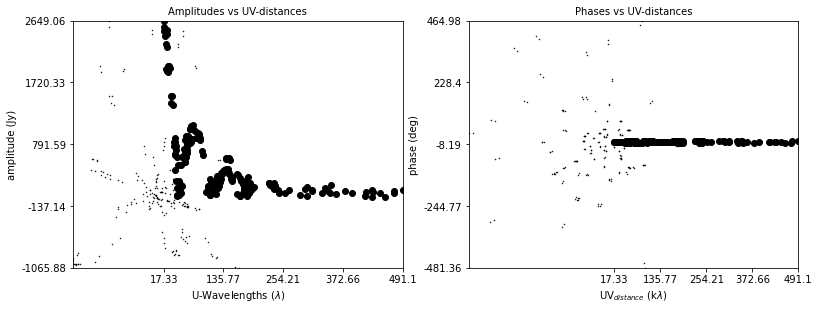

In [5]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()

__Settings__

The `SettingsPhaseInterferometer` describe how the model is fitted to the data in the log likelihood function.

These settings are used and described throughout the `autolens_workspace/notebooks/interferometer/modeling` example scripts, with a 
complete description of all settings given in `autolens_workspace/notebooks/interferometer/modeling/customize/settings.py`.

The settings chosen here are applied to all phases in the pipeline.

In [6]:
settings_masked_interferometer = al.SettingsMaskedInterferometer(
    grid_class=al.Grid2D, sub_size=2, transformer_class=al.TransformerNUFFT
)

settings = al.SettingsPhaseInterferometer(
    settings_masked_interferometer=settings_masked_interferometer
)

__Pipeline_Setup__:

Pipelines use `Setup` objects to customize how different aspects of the model are fitted. 

First, we create a `SetupMassTotal`, which customizes:

 - The `MassProfile` used to fit the lens's total mass distribution.
 - If there is an `ExternalShear` in the mass model or not.

In [7]:
setup_mass = al.SetupMassTotal(with_shear=True)

Next, we create a `SetupSourceParametric` which customizes:

 - The `LightProfile`'s which fit different components of the source light, such as its `bulge` and `disk`.
 - The alignment of these components, for example if the `bulge` and `disk` centres are aligned.
 
In this example we fit the source light as one component, a `bulge` represented as an `EllipticalSersic`. We have 
included options of `SetupSourceParametric` with input values of `None`, illustrating how it could be edited to fit different models.

In [8]:
setup_source = al.SetupSourceParametric()

_Pipeline Tagging_

The `Setup` objects are input into a `SetupPipeline` object, which is passed into the pipeline and used to customize
the analysis depending on the setup. This includes tagging the output path of a pipeline. For example, if `with_shear` 
is True, the pipeline`s output paths are `tagged` with the string `with_shear`.

This means you can run the same pipeline on the same data twice (e.g. with and without shear) and the results will go
to different output folders and thus not clash with one another!

The `path_prefix` below specifies the path the pipeline results are written to, which is:

 `autolens_workspace/output/pipelines/dataset_type/dataset_name` 
 `autolens_workspace/output/pipelines/interferometer/mass_sie__source_sersic_x2/`
 
 The redshift of the lens and source galaxies are also input (see `notebooks/interferometer/modeling/customize/redshift.py`) for a 
description of what inputting redshifts into **PyAutoLens** does.

In [9]:
setup = al.SetupPipeline(
    path_prefix=path.join("pipelines", dataset_name),
    redshift_lens=0.5,
    redshift_source=1.0,
    setup_mass=setup_mass,
    setup_source=setup_source,
)

__Pipeline Creation__

To create a pipeline we import it from the pipelines folder and run its `make_pipeline` function, inputting the 
`Setup` and `SettingsPhase` above.

In [10]:
from pipelines import mass_total__source_parametric

pipeline = mass_total__source_parametric.make_pipeline(
    setup=setup, settings=settings, real_space_mask=real_space_mask
)

__Pipeline Run__

Running a pipeline is the same as running a phase, we simply pass it our lens dataset and mask to its run function.

In [11]:
pipeline.run(dataset=interferometer, mask=visibilities_mask)


INFO:autofit.tools.pipeline:Running Phase phase[1]_mass[sie]_source[parametric] (Number 0)
INFO:root:phase[1]_mass[sie]_source[parametric] already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[2]__source_inversion_initialization (Number 1)
INFO:root:phase[2]__source_inversion_initialization already completed, skipping non-linear search.
